# Track Modeling for Lap Time Simulation

**Author**: Carlos Hermoso  
**Date**: 2025-07-04  
**Version**: 1.2  
**Project**: F1 Engineering


> *Note: This notebook relies on internal source code which is not publicly available.  
> If you're interested in accessing or discussing the implementation, feel free to [connect with me on LinkedIn](https://www.linkedin.com/in/carloshermoso).*  



This notebook focuses on **track modeling** — the process of converting a circuit layout from raw $X$, $Y$ coordinate data into a structured list of **track segments**.

Each segment is classified as either a:

- **Straight**, defined by its start and end points, and
- **Turn**, defined by its entry, apex, and exit points, along with geometric properties such as:
  - **Radius** (in meters)
  - **Arc Length**
  - **Turn Direction**

---

The main goal is to convert the continuous GPS data into a usable **sequence of turns and straights**, which can be later fed into a **lap time simulator**. 

With this structured format, we can simulate lap times using:

- Vehicle acceleration and braking models
- Speed profiles computed from turn radii
- Segment-by-segment time integration

Ultimately, this enables predictive simulation and performance analysis for any vehicle on any track.


In [1]:
from data_loading.data_fetch import DataFetch
from models.track_model import Track
from plotting.track_plot import TrackPlot

In [2]:
DataFetch.enable_cache('../cache')
print(Track.list_available_tracks())

['Bahrain', 'Jeddah', 'Melbourne', 'Suzuka', 'Shanghai', 'Miami', 'Imola', 'Monaco', 'Barcelona', 'Montreal', 'Red Bull Ring', 'Silverstone', 'Hungaroring', 'Spa', 'Zandvoort', 'Monza', 'Baku', 'Singapore', 'COTA', 'Mexico City', 'Interlagos', 'Las Vegas', 'Lusail', 'Abu Dhabi']


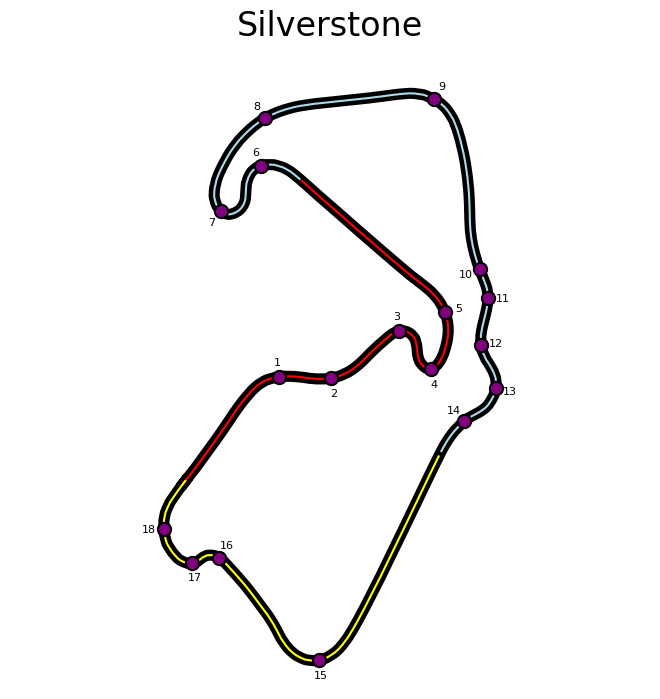

In [3]:
track = Track.load("Silverstone")
track_plot = TrackPlot(track)

fig, ax = track_plot.plot_circuit()

##  Fitting a Circle to Telemetry Data

Before identifying turn arcs, we need to estimate the **radius** and **center** of each corner. This is done by fitting a circle to the GPS points near each corner using a **least squares** method.

###  Mathematical Background

A circle with center at $(x_c, y_c)$ and radius $r$ satisfies the equation:

$$
(x - x_c)^2 + (y - y_c)^2 = r^2
$$

Rewriting it in a linear form suitable for least squares fitting:

$$
x^2 + y^2 = 2x_c x + 2y_c y + c
$$

We treat this as a linear system:

$$
A \cdot \beta = b
$$

Where:
- $A = \begin{bmatrix} 2x & 2y & 1 \end{bmatrix}$
- $\beta = \begin{bmatrix} x_c \\ y_c \\ c \end{bmatrix}$
- $b = x^2 + y^2$

Solving for $\beta$ gives us the center coordinates and a constant term, from which we calculate the radius:

$$
r = \sqrt{x_c^2 + y_c^2 + c}
$$



This method gives us a good initial estimate of the turn geometry that we’ll later use to define arc segments.
> **Note:** This radius is not the actual physical radius in meters. It represents the radius in the X,Y coordinate space of the telemetry data, which is projected and scaled. The true driving radius (in meters) will be calculated later based on distance data.


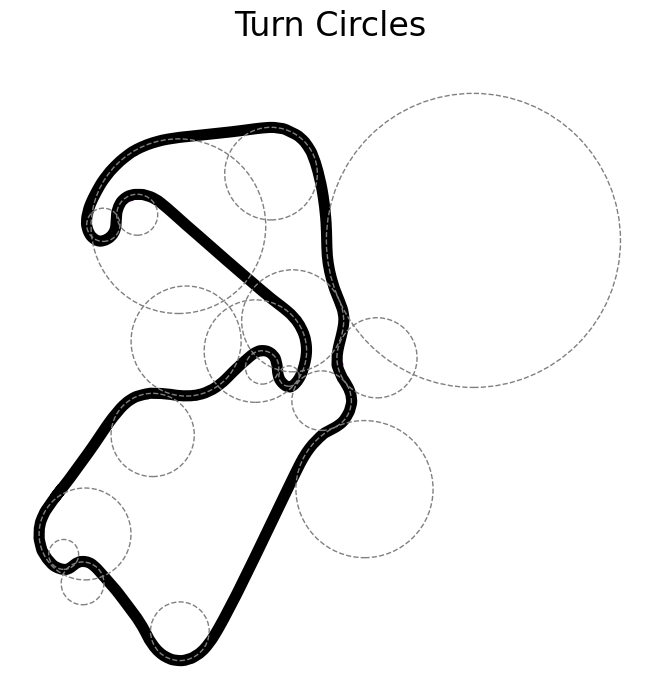

In [4]:
fig, ax = track_plot.plot_turn_circles()

## Defining Turn Arcs from Fitted Circles

Once we have the estimated circle for each corner (from the X,Y telemetry points), the next step is to extract the portion of the circle that the car actually follows — this is what we call the **turn arc**.

### Step 1: Identify the Apex

For each turn, we use the known corner apex position provided by the circuit data. We locate the nearest telemetry point to this apex to center a search window around it.

### Step 2: Windowed Search for Arc Points

We consider a fixed number of telemetry points before and after the apex — forming a symmetric **search window**. This captures the part of the lap where the car is physically rotating around the turn.

Let the circle center be $(x_c, y_c)$ and its radius be $r$. For each telemetry point $(x_i, y_i)$ in the window, we compute its distance to the center:

$$
d_i = \sqrt{(x_i - x_c)^2 + (y_i - y_c)^2}
$$

We then check whether the point lies approximately on the fitted circle. This is done by verifying:

$$
|d_i - r| < \varepsilon
$$

Where $\varepsilon$ is a **tolerance threshold** — points that satisfy this condition are considered part of the arc.

### Result: The Arc Segment

The resulting set of "arc points" represents the portion of the corner the car actually drives through. This allows us to compute:

- The **arc length** from telemetry distances
- The **entry, apex, and exit** points of the corner
- The **turn direction**, using vector geometry

>  This arc is now a usable track segment — it reflects the car's actual path through the corner, not just the geometric center of the curve.


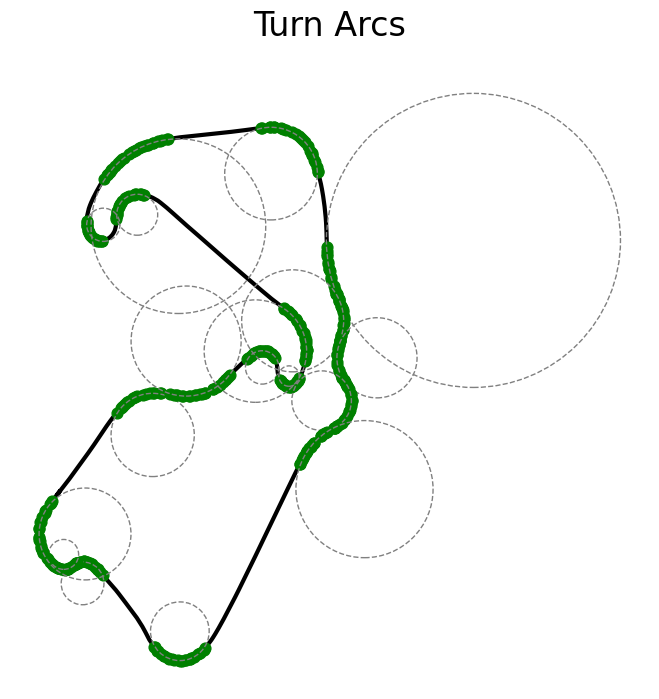

In [5]:
fig, ax = track_plot.plot_arcs()

## Converting Geometric Radius to Physical Radius in Meters

The initial radius we calculated from the telemetry data was based on **X, Y coordinate units**, not real-world meters. To simulate vehicle dynamics accurately (like braking, grip, and acceleration), we must convert this geometric radius into **a physical radius in meters**.

### Using Arc Length and Angle

We achieve this conversion using the relationship between arc length, angle, and radius:

$$
r = \frac{L}{\theta}
$$

Where:

- $r$ is the **radius in meters** (what we want to compute).
- $L$ is the **arc length in meters**, directly obtained from the telemetry (`Distance` column).
- $\theta$ is the **angle in radians** subtended by the arc.


---

### How We Compute Each Quantity

- **Arc Length ($L$):** This comes from subtracting the telemetry distance at the arc's end point from the distance at the start point. These distances are cumulative meters traveled along the lap.
  
- **Angle ($\theta$):** We compute the angle between the vectors from the circle's center to the arc's start and end points:

$$
\theta = \cos^{-1} \left( \frac{\vec{v}_1 \cdot \vec{v}_2}{\|\vec{v}_1\| \|\vec{v}_2\|} \right)
$$

Where:

- $\vec{v}_1 = \begin{bmatrix} x_{\text{start}} - x_c \\ y_{\text{start}} - y_c \end{bmatrix}$  
- $\vec{v}_2 = \begin{bmatrix} x_{\text{end}} - x_c \\ y_{\text{end}} - y_c \end{bmatrix}$

These vectors originate from the **circle center** and point toward the **start and end of the arc**.




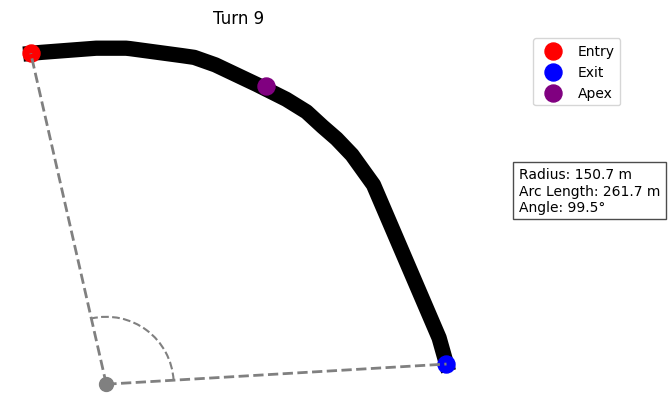

In [6]:
fig, ax = track_plot.plot_turn_geometry(turn_num=9)

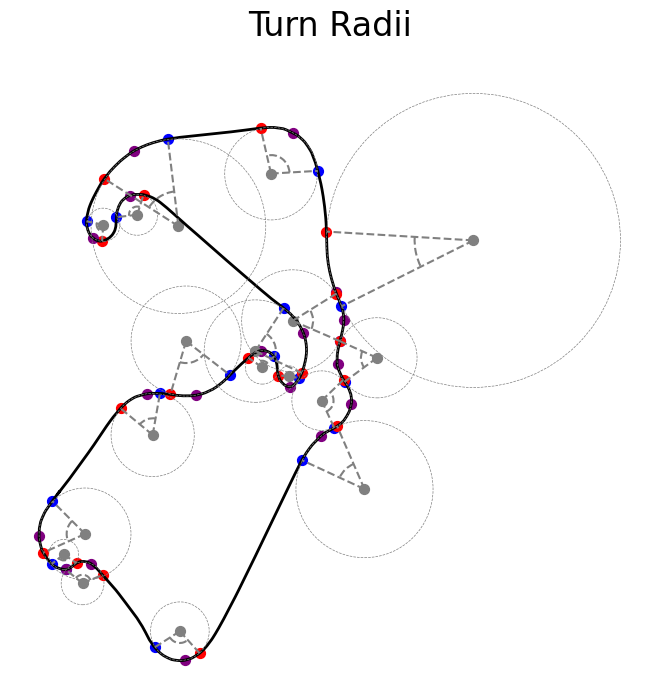

In [7]:
fig, ax = track_plot.plot_turns_geometry()

## Track Modeling: Segmenting the Circuit

To build a complete, analyzable model of the circuit, we divide the entire lap into discrete **segments** — either a **turn** or a **straight**. This segmentation allows us to simulate the vehicle's behavior through each distinct part of the lap.

---

### Segment Types

Each segment is categorized as:

- **Turn:** Defined by an arc around a computed center point and radius.
- **Straight:** A direct line connecting two arc endpoints (i.e., from the end of one turn to the start of the next).

---

### Step-by-Step Logic

#### 1. **Start with the Finish Line**
The model begins at the finish line. The first segment is the **start/finish straight**, which runs from the finish line to the start of the first turn's arc.

#### 2. **Loop Through All Corners**
For each corner in the circuit:

- We identify the **arc of the turn**, using the center and radius computed earlier.
- Using the arc’s start and end points, we determine:
  - The **physical radius** of the turn (in meters).
  - The **length** of the turn (arc length).
  - The **direction** (Left or Right), based on the vector geometry.
- This becomes a **Turn segment** in the model.

#### 3. **Insert Straights Between Turns**
Between each pair of consecutive turns:
- We add a **Straight segment** that connects the **exit** of the current turn to the **entry** of the next one.
- This is only done if the two arcs **do not overlap**. If one turn begins before the previous has ended, the straight is skipped.

#### 4. **Finish with Final Straight**
After the last turn, we add the final straight segment that connects the end of the last arc back to the finish line — completing the loop.

---

### Segment Structure

Each segment is described by its:

- **Type**: `"Turn"` or `"Straight"`
- **Length** (meters)
- **Start & End $XY$** coordinates
- **Distance** (meters from finish line)
- For turns only:
  - **Turn Number** and **Direction**
  - **Radius** (in meters)
  - **Apex $XY$** 
  - **Center $XY$** of the turn’s circle
  - **Radius $XY$** (for plotting purposes)


In [8]:
track.segments_df.head()

,Type,Length,Start X,Start Y,End X,End Y,Distance,Turn Number,Turn Direction,Radius,Center X,Center Y,Apex X,Apex Y,Radius_XY
0,Straight,320.11,-1656.94,1340.59,191.47,3883.41,0.00,,,0.00,,,,,
1,Turn,170.02,191.47,3883.41,1634.93,4515.51,431.14,1,Right,138.41,1360.142361,3175.393696,1192.508301,4503.826172,1344.913415
2,Straight,23.10,1634.93,4515.51,1932.23,4486.67,501.69,,,0.00,,,,,
3,Turn,218.52,1932.23,4486.67,3856.00,5111.00,605.53,2,Left,182.48,2440.479592,6209.930607,2770.315186,4462.89209,1778.29056
4,Straight,66.61,3856.00,5111.00,4392.62,5615.48,765.06,,,0.00,,,,,


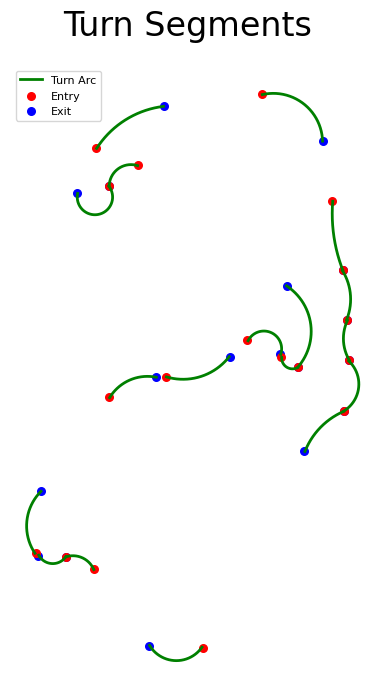

In [9]:
fig, ax = track_plot.plot_arcs_segments()

## Final Model: The Track as a Sequence of Segments

With all the geometric information extracted, we now represent the entire track as a sequence of **segments** — either a **turn** or a **straight**.

---

This structured representation allows us to treat the circuit not just as a collection of XY points, but as a logical progression of driving challenges — alternating between high-speed straights and dynamic corners. It becomes the foundation for everything that follows: lap time estimation, physics-based simulation, and performance analysis.


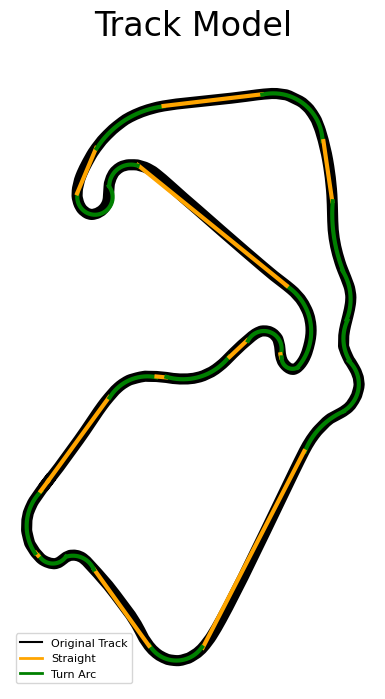

In [10]:
fig, ax = track_plot.plot_segments()

In [12]:
track.segments_df[['Turn Number','Length','Radius']]

,Turn Number,Length,Radius
0,,320.11,0.00
1,1,170.02,138.41
2,,23.10,0.00
3,2,218.52,182.48
4,,66.61,0.00
5,3,166.03,55.52
6,,9.54,0.00
7,4,67.96,33.10
8,5,290.85,169.74
9,,573.49,0.00
